# OISSTv2 Live Updating Workflow

This notebook is for documenting the steps to build a single annual OISSTv2 file using update caches. The processing of global anomalies, and the regional timelines that we keep on hand for analyses. 

The steps were developed initially in `Update_01_Download_OISST` then the steps were abstracted into functions and placed into the `oisstools.py` module. This notebook will follow the same steps but with much less code, hopefully with less room for error.

This notebook exists to document the processing steps, but has since been replaced by script workflows using prefect in `oisst_prefect.py`. Use this notebook for debugging or extending the workflow, then transfer to `oisst_prefect.py`

In [1]:
# Libraries
from bs4 import BeautifulSoup
import requests
import os
import xarray as xr
import datetime
import oisstools as ot


#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")
_cache_root = ot.set_cache_root(box_root)

# Manual Month/Year Selection
# last_month = "11"
# this_month = "12"
# update_yr = "2022"


#### 2. What Months are we checking?
this_month = ot.get_update_month(return_this_month = True)
last_month = ot.get_update_month(return_this_month = False)
update_yr  = ot.check_update_yr(for_this_month = True)


# Specify year range to update for anomaly timeseries
yr_min = update_yr
yr_max = update_yr


# variable name to mask and make timeline from
var_name = "sst"


#### 3. Print Last Update
print(f"Working via directory at: {box_root}")
print(f"Updated using months:     {last_month} & {this_month}, Year: {update_yr}")
print(f"Updating Year(s):         {yr_min} - {yr_max}")

Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/
Updated using months:     01 & 02, Year: 2022
Updating Year(s):         2022 - 2022


## 1. Download Daily Files for Last Month

In [2]:
# os. listdir('/Users/akemberling/Library/CloudStorage/') # Check that the root directory isn't broken

In [3]:
# Use cache_oisst function to update cache for last month
if last_month != "12":
    ot.cache_oisst(cache_month = last_month, 
                   update_yr = update_yr, 
                   workspace = workspace, 
                   verbose = True)
else:
    print("Last month not updated because of year transition")    

Caching Daily NETCDF File: oisst-avhrr-v02r01.20220101.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220102.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220103.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220104.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220105.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220106.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220107.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220108.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220109.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220110.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220111.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220112.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220113.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220114.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220115.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220116.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220117.nc
Caching Daily 

## 2. Download Daily Files for This Month

In [4]:
# Use cache_oisst function to update cache for current month
ot.cache_oisst(cache_month = this_month, 
               update_yr = update_yr, 
               workspace = workspace, 
               verbose = True)

Caching Daily NETCDF File: oisst-avhrr-v02r01.20220201.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220202.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220203.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220204.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220205.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220206_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220207_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220208_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220209_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220210_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220211_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220212_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220213_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220214_preliminary.nc
Caching Daily NETCDF File: oisst-avhrr-v02r01.20220215_preliminary.nc
Caching Da

## 3. Build Annual File

In [5]:
# Assemble the annual file
oisst_update = ot.build_annual_from_cache(last_month = last_month, 
                                          this_month = this_month, 
                                          workspace = workspace, 
                                          verbose = True)

## 4. Check Annual file

Want to see consistency in the dimensions, and data from the beginning of the year through to the update month.

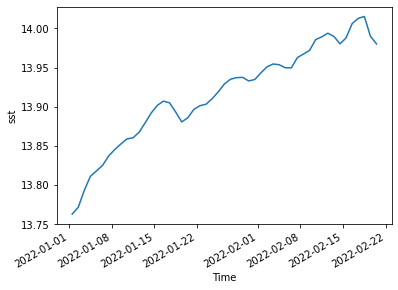

In [6]:
#oisst_update
oisst_update.sst.mean(("lon", "lat")).plot()

## 5. Export Update

In [7]:
# export update using same file pattern as everything else
ot.export_annual_update(cache_root = _cache_root,
                        update_yr = update_yr,
                        oisst_update = oisst_update)

File Saved to /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean.2022.v2.nc


## 6. Update Annual Anomalies

This step has the opportunity to update anomalies for a range of years, the default update year is the `update_yr` value set at the top of the notbeook.

In [8]:
# Set desired climatology period
reference_period = "1982-2011"
print(f"Calculating Anomalies for {reference_period} reference period.")

# Process Global Anomalies for the select years
ot.update_global_anomalies(yr_min = yr_min, 
                           yr_max = yr_max, 
                           box_root = box_root, 
                           var_name = "sst", 
                           reference_period = "1982-2011")

Updating Year(s): 2022 - 2022
Calculating Anomalies for 1982-2011 reference period.
Saving anomaly year: 2022


## 7. Update Global Timeseries

In [2]:
# Update the timeseries of global temps/anoms
ot.update_global_timeseries(yr_min, yr_max, box_root, var_name = "sst", reference_period = "1982-2011")

Updating Global Timeseries


## 8. Regional timeseries 

In [2]:
#### Update the regional timeseries groups: ####

# GMRI Focal Areas
ot.update_regional_timeseries_collection(start_yr = yr_min, end_yr = yr_max, region_collection = "gmri_sst_focal_areas", box_root = box_root)

# Northeast Marine Regions
ot.update_regional_timeseries_collection(start_yr = yr_min, end_yr = yr_max, region_collection = "nelme_regions", box_root = box_root)

# NMFS Trawl Regions
ot.update_regional_timeseries_collection(start_yr = yr_min, end_yr = yr_max, region_collection = "nmfs_trawl_regions", box_root = box_root)

# Gulf of Maine Physio Regions
ot.update_regional_timeseries_collection(start_yr = yr_min, end_yr = yr_max, region_collection = "gom_physio_regions", box_root = box_root)

# Large Marine Ecosystems
ot.update_regional_timeseries_collection(start_yr = yr_min, end_yr = yr_max, region_collection = "lme", box_root = box_root)

Updating Timeseries for: gmri_sst_focal_areas
Updating Timeseries for:
 - apershing_gulf_of_maine
 - cpr_gulf_of_maine
 - aak_northwest_atlantic
 - long_island_sound


CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

---

# 9. TESTING: Make Monthly Files

Debugging: Having errors with how time is stored in 2021 vs. other years

In [ ]:
temp_20 = ot.load_box_oisst(box_root, start_yr = 2020, end_yr = 2020, anomalies = False, do_parallel = True)
temp_20.time.attrs

{'long_name': 'Time',
 'delta_t': '0000-00-01 00:00:00',
 'avg_period': '0000-00-01 00:00:00',
 'axis': 'T',
 'actual_range': array([80353., 80718.])}

In [ ]:
temp_21 = ot.load_box_oisst(box_root, start_yr = 2021, end_yr = 2021, anomalies = False, do_parallel = True)
temp_21.time.attrs 

In [39]:
xr.concat([temp_20, temp_21], dim = "time")

<xarray.Dataset>
Dimensions:  (time: 762, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2021-12-31T12:00:00
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(366, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [10]:
# Load all the daily files we have
oisst_temp_daily = ot.load_box_oisst(box_root, start_yr = 2021, end_yr = update_yr, anomalies = False, do_parallel = True)
oisst_anoms_daily = ot.load_box_oisst(box_root, start_yr = 1981, end_yr = update_yr, anomalies = True, do_parallel = True)

In [11]:
# Use resample to get monthly averages for each year - keeps index of time
oisst_months = oisst_temp_daily.resample(time = "1M").mean(dim = "time")

In [12]:
anom_months = oisst_anoms_daily.resample(time = "1M").mean(dim = "time")
# oisst_months.sst.isel(time = 5).plot()
# anom_months.sst.isel(time = 5).plot()

# Combine to same Dataset
month_tidy = xr.merge([oisst_months, anom_months.rename({"sst": "sst_anom"})])

# Set Attributes: TBD



/Users/akemberling/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [ ]:
# Save out monthly netcdf
out_path = f'{box_root}RES_Data/OISST/oisst_mainstays/monthly_averages/oisst_monthly.nc'
month_tidy.to_netcdf(out_path)
print("Saving Monthly Averages")